# **Milestone 2 Phase 2**

## **`1. Perkenalan`**

**Nama   : Andika Atmanegara Putra**

**Batch  : FTDS - RMT - 019**

---

`1.1. Problem Statement` 

Dengan menggunakan dataset yang tersedia pada link berikut: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection, akan dilakukan pemodelan untuk memprediksi apakah terdapat retakan (crack) pada suatu area seperti dinding ataupun jalan. Dengan dapat diprediksinya crack pada suatu area, proses inspeksi gedung menjadi lebih mudah dengan hanya melakukan upload foto pada sistem yang telah memiliki database beserta prediksi untuk mengetahui adanya crack atau tidak crack.


---


`1.2. Objective`

Mempersiapkan dataset dengan preprocessing, melakukan explorasi dataset, menganalisa dan mengimplementasikan `Convolutional Neural Network` (CNN) untuk memprediksi keretakan suatu area, kemudian melakukan improvement pada model yang telah dibuat.


---



`1.3. Metode Background`

Pada proses pembuatan model untuk mendeteksi crack akan dilakukan dengan 2 cara yaitu `Functional API` sebagai base model dan `Improved Functional API` sebagai improvement dari base model. Daru 2 cara tersebut akan diamati metric seperti accuracy, precition, recall, dan F1-Score. 

Fokus utama metric amatan adalah `F1-Score`. Alasan dipilihnya metric ini sebagai fokus amatan adalah untuk meminimalisir **kesalahan prediksi**, baik berupa kesalahan **false positive** ataupun **false negative**. Dilihat dari domain konstruksi, keretakan pada suatu area terutama area dinding tidak boleh terjadi dan harus segera dihandle oleh pihak/perusahaan konstruktor. Oleh karena itu, model haruslah dapat meminimalisir kesalahan prediksi tersebut.  

## **`2. Import Libraries`**

In [ ]:
# # Install kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Basic & Visualisasi
import os
import glob
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.image import imread
from pathlib import Path

# Preprocessing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Model
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, BatchNormalization 

# Evaluation
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Inference and Evaluation
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
import requests
from PIL import Image

# other
import warnings
warnings.filterwarnings('ignore')
import pickle
import json

## **`3. Data Loading`**

Pada data loading, saya melakukan proses pengambilan gambar pada dataset yang berjumlah 40.000 pcs image yang terdiri dari 20.000 image dengan label 'POSITIVE' atau Crack dan label 'NEGATIVE' atau No Crack. 

In [ ]:
# mount drive ke google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# buat folder baru di collab
!mkdir ~/.kaggle

# copy folder ke kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beemabee","key":"1155b68a1d2f4820042f23d944c9846f"}'}

In [ ]:
# pindahkan file ke directory root
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [ ]:
# ubah izin file agar dapat di read
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#download dataset
!kaggle datasets download -d arunrk7/surface-crack-detection

 96% 223M/233M [00:03<00:00, 65.6MB/s]
100% 233M/233M [00:03<00:00, 63.2MB/s]


In [ ]:
# unzip dataset dan dimasukkan pada folder dataset
!unzip -q /content/surface-crack-detection.zip -d dataset

In [ ]:
# define main_path 
main_path = '/content/dataset/'
os.listdir(main_path)

['Negative', 'Positive']

In [ ]:
# Ubah directory path ke dalam object path 
positive_dir = Path('/content/dataset/Positive')
negative_dir = Path('/content/dataset/Negative')

## **`4. Exploratory Data Analysis`**

###  **4.1. Create Dataframe**

In [ ]:
# buat dataframe untuk mengasosiasikan posisi image dengan label
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    
    return df

In [ ]:
# Check Positive DataFrame
positive_df = generate_df(positive_dir, 'POSITIVE')
positive_df.head()

Filepath     Label
0    /content/dataset/Positive/02086.jpg  POSITIVE
1    /content/dataset/Positive/09569.jpg  POSITIVE
2    /content/dataset/Positive/03419.jpg  POSITIVE
3  /content/dataset/Positive/14292_1.jpg  POSITIVE
4    /content/dataset/Positive/19477.jpg  POSITIVE

In [ ]:
# Check Negative DataFrame
negative_df = generate_df(negative_dir, 'NEGATIVE')
negative_df.head()

Filepath     Label
0  /content/dataset/Negative/02086.jpg  NEGATIVE
1  /content/dataset/Negative/19125.jpg  NEGATIVE
2  /content/dataset/Negative/09569.jpg  NEGATIVE
3  /content/dataset/Negative/03419.jpg  NEGATIVE
4  /content/dataset/Negative/19477.jpg  NEGATIVE

In [ ]:
# merge dataframe menjadi satu kesatuan
data = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

Filepath     Label
0    /content/dataset/Negative/02927.jpg  NEGATIVE
1  /content/dataset/Positive/16000_1.jpg  POSITIVE
2    /content/dataset/Negative/18893.jpg  NEGATIVE
3  /content/dataset/Positive/12232_1.jpg  POSITIVE
4    /content/dataset/Negative/14961.jpg  NEGATIVE

In [ ]:
# show shape dataframe
print(data.shape)

(40000, 2)


### **4.2. Visualisasi Dataset**



#### **4.2.1. Distirbusi Dataset**



Text(0.5, 1.0, 'Label')

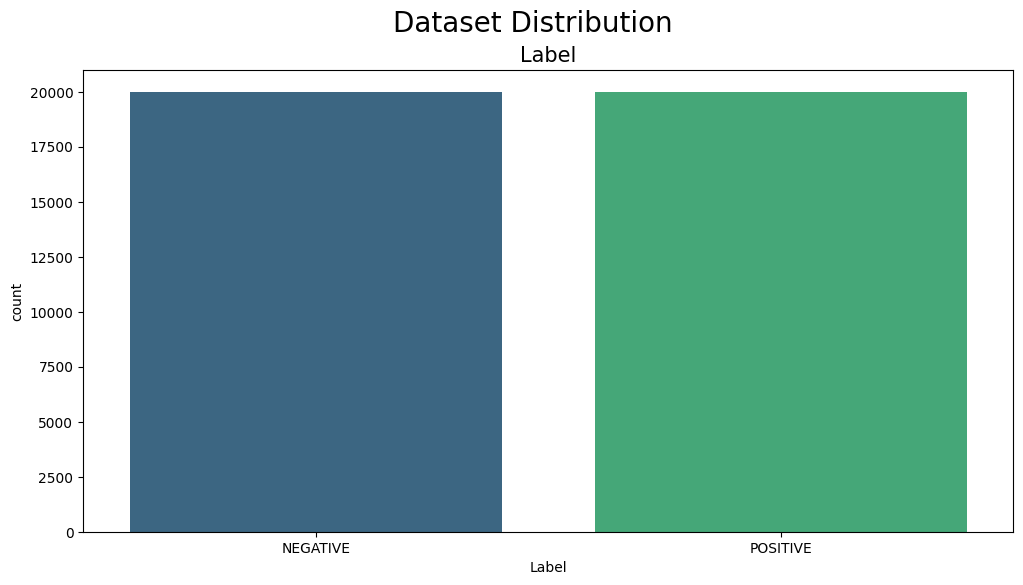

In [ ]:
# Check Distribusi Data antara Crack dengan Tidak Crack
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
plt.suptitle('Dataset Distribution', fontsize=20)
sns.countplot(x='Label', data=data, palette='viridis')
ax.set_title('Label', fontsize=15)

Dari gambar diatas, terlihat dataset adalah berimbang antara data 'POSITIVE' atau Crack yang berjumlah 20.000 dengan data 'NEGATIVE' atau No Crack yang berjumlah 20.000 juga.

#### **4.2.2. Normal Image Based on Color / RGB**

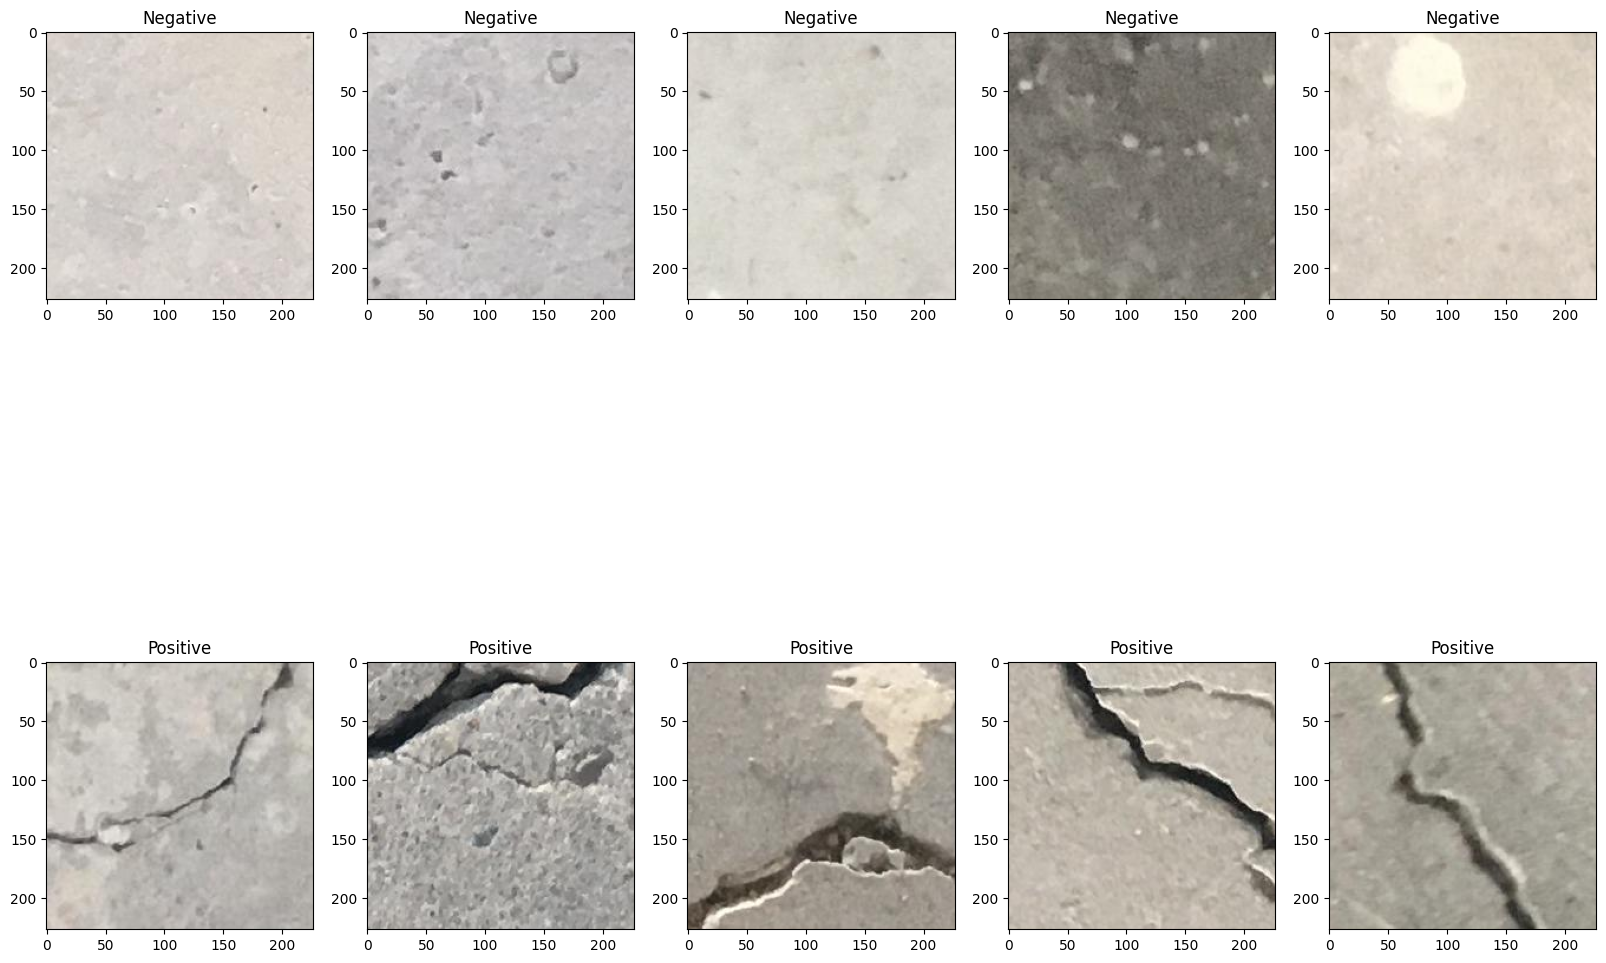

In [ ]:
# define sample of dataset
negative_sample = (data[data['Label']=='NEGATIVE']['Filepath'].iloc[:5]).tolist()
positive_sample = (data[data['Label']=='POSITIVE']['Filepath'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=2, ncols=5, figsize= (20,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('/')[-2])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
# Execute the function
visualize_samples(negative_sample + positive_sample)

- Untuk selanjutnya data dengan label "NEGATIVE" akan disebut normal/No Crack dan data dengan label "POSITVE" akan disebut dengan Crack. 

- Data sampling diatas menunjukkan pada dataset, untuk gambar normal maupun gambar crack terlihat mayoritas warna adalah gabungan dari warna coklat, putih, dan abu-abu. Dengan gambar keretakan berada di sebagian tengah gambar yang membagi gambar menjadi 2 bagian baik secara vertikal maupun horizontal.


#### **4.2.3. Hue, Saturation, Brightness Image**

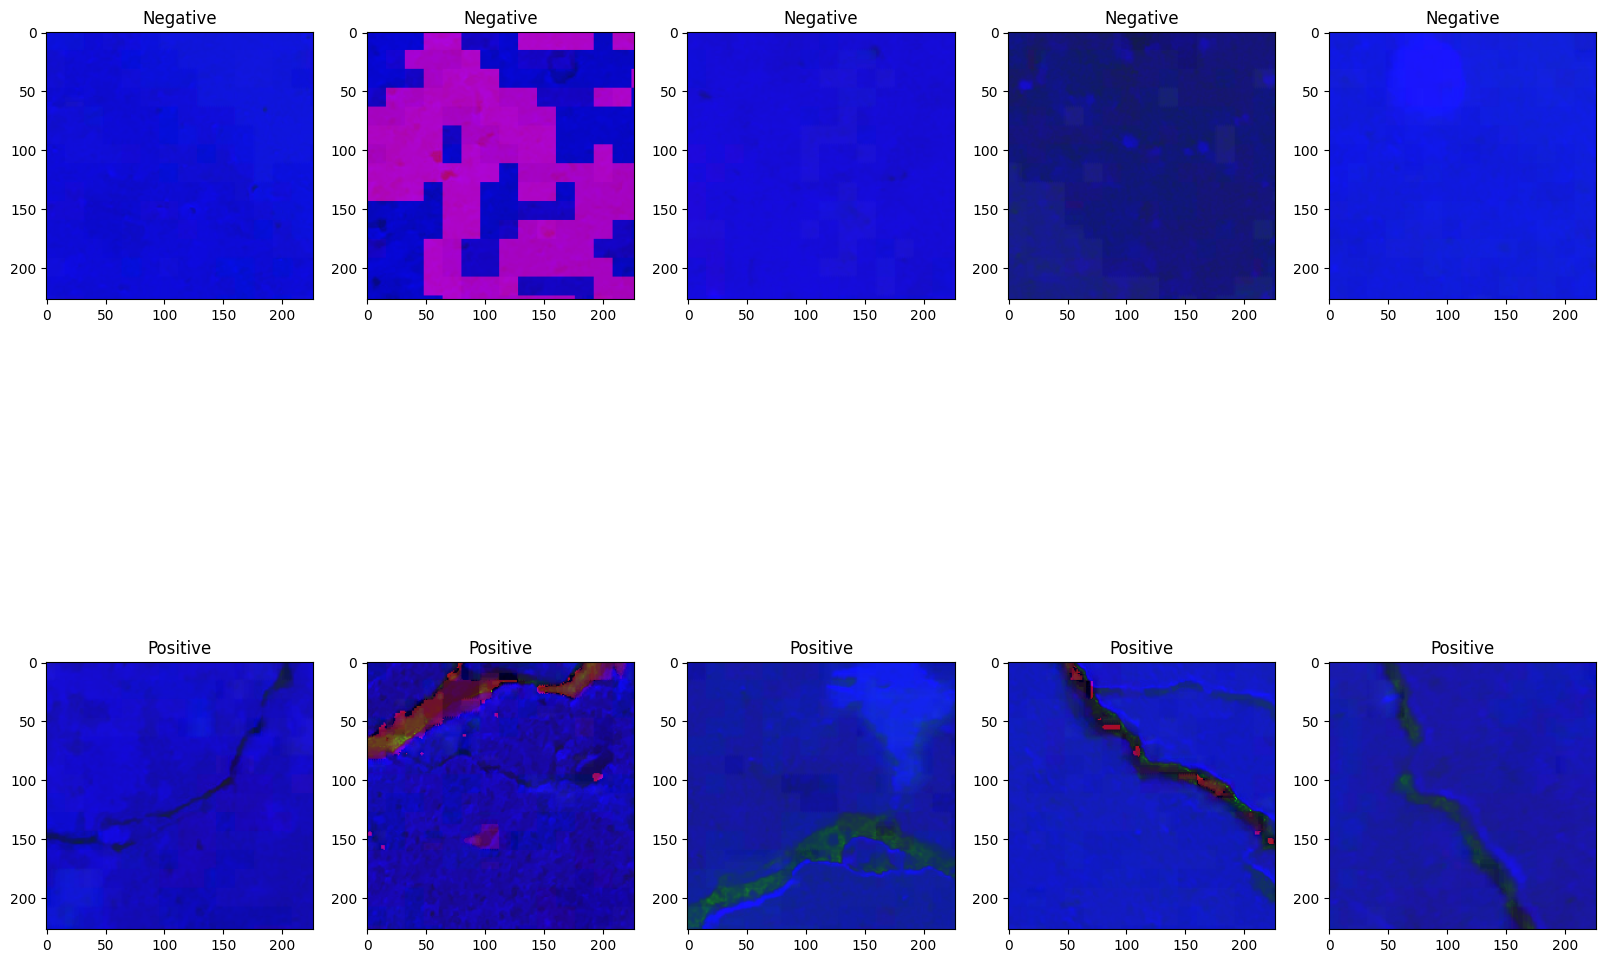

In [ ]:
# define sample of dataset
negative_sample = (data[data['Label']=='NEGATIVE']['Filepath'].iloc[:5]).tolist()
positive_sample = (data[data['Label']=='POSITIVE']['Filepath'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convert to HSB color space
        ax[i // 5, i % 5].set_title(sample.split('/')[-2])
        ax[i // 5, i % 5].imshow(img_hsv)
    plt.show()
# Execute the function
visualize_samples(negative_sample + positive_sample)

Pada step ini image dataset dirubah metric hue, saturation, dan brightness untuk memberikan tambahan informasi terkait distribusi warna. Hal ini dapat membantu dalam memahami variasi warna yang mungkin ada dalam dataset, dan apakah variasi tersebut berhubungan dengan label (misalnya, jika ada perbedaan warna yang signifikan antara gambar dengan label "Crack" dan "Not Crack").

Dari dataset terlihat untuk label "Not Crack" warna yang dihasilkan mayoritas biru namun ada juga yang mayoritas ungu mungkin berkorelasi dengan intensitas cahaya yang mengenai surface area normal tersebut sehingga menimbulkan warna selain biru

Untuk label Crack sebagian besar dari sample berwarna biru untuk porsi tidak ada crack nya, namun di crack akan berwarna berbeda dan berpola seperti merah ataupun warna hijau.

#### **4.2.4. LUV Color Image**


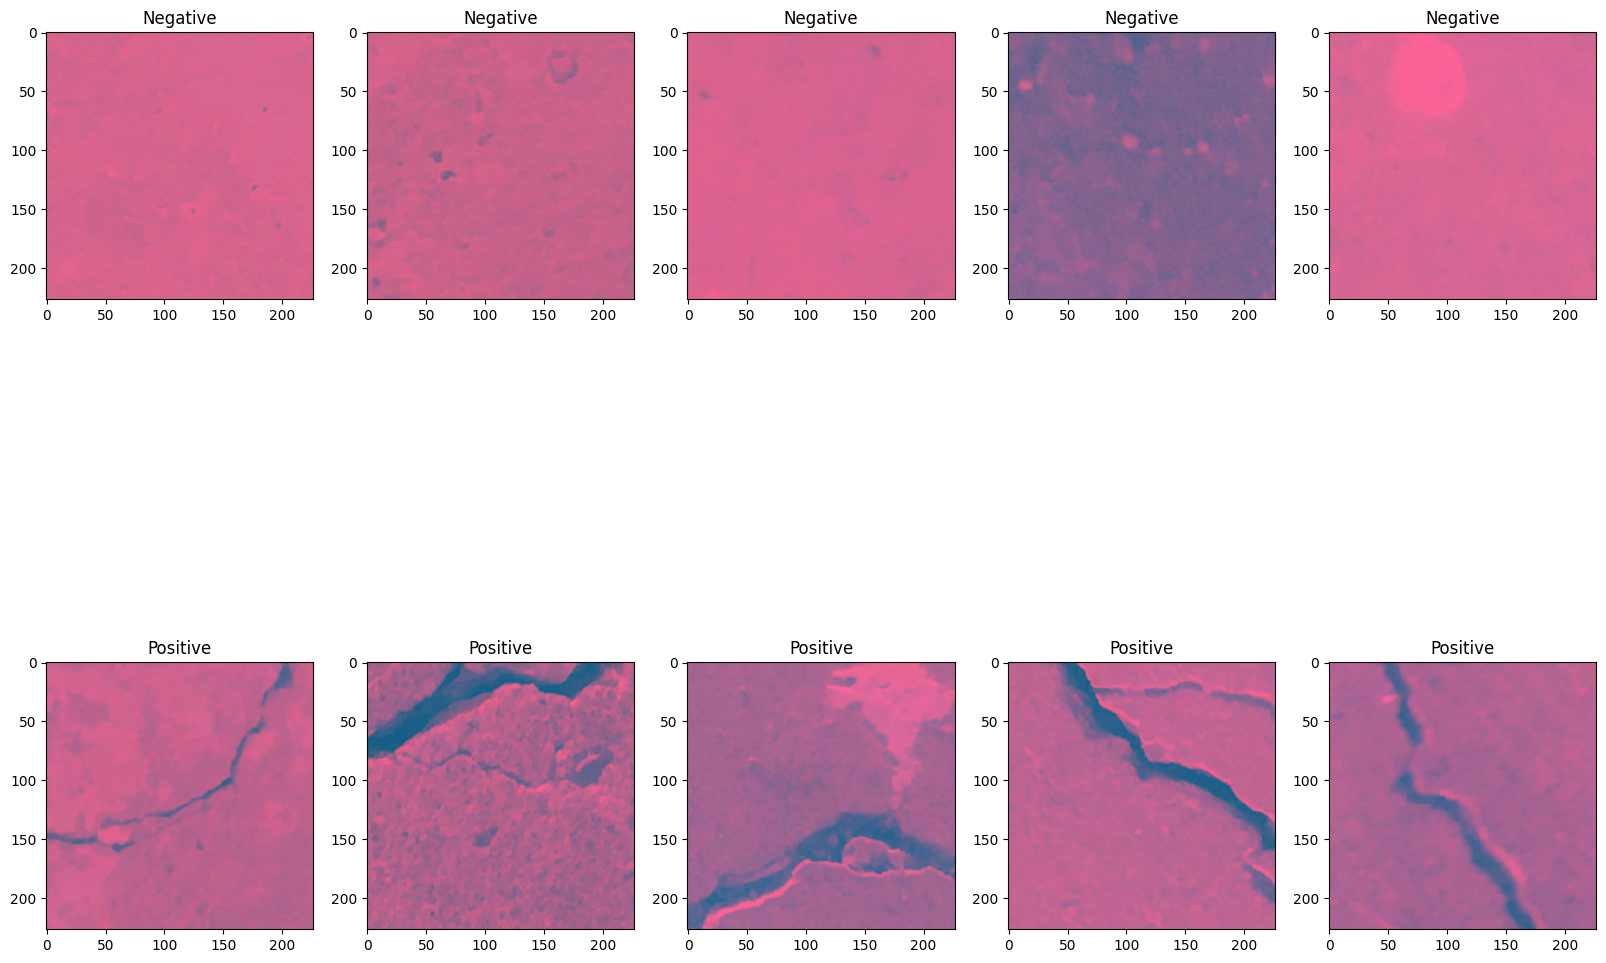

In [ ]:
# define sample of dataset
negative_sample = (data[data['Label']=='NEGATIVE']['Filepath'].iloc[:5]).tolist()
positive_sample = (data[data['Label']=='POSITIVE']['Filepath'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        img_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)  # Convert to LUV color space
        ax[i // 5, i % 5].set_title(sample.split('/')[-2])
        ax[i // 5, i % 5].imshow(img_luv)
    plt.show()
# Execute the function
visualize_samples(negative_sample + positive_sample)

Transformasi LUV (Luminance, Chrominance) pada image dapat memberikan informasi tambahan juga pada distribusi warna. Transformasi LUV dilakukan dengan mengubah ruang warna dari BGR (Blue-Green-Red) menjadi LUV, menggunakan fungsi cv2.cvtColor dari library OpenCV.Transformasi LUV dapat membantu dalam melihat variasi kecerahan dan warna dalam dataset gambar.

Dari dataset gambar mayoritas dataset baik normal maupun crack akan menunjukkan warna kemerahan, terkecuali pada area crack akan menunjukkan warna hitam yang menandakan adanya crack pada surface tersebut.



#### **4.2.5. Grayscale**

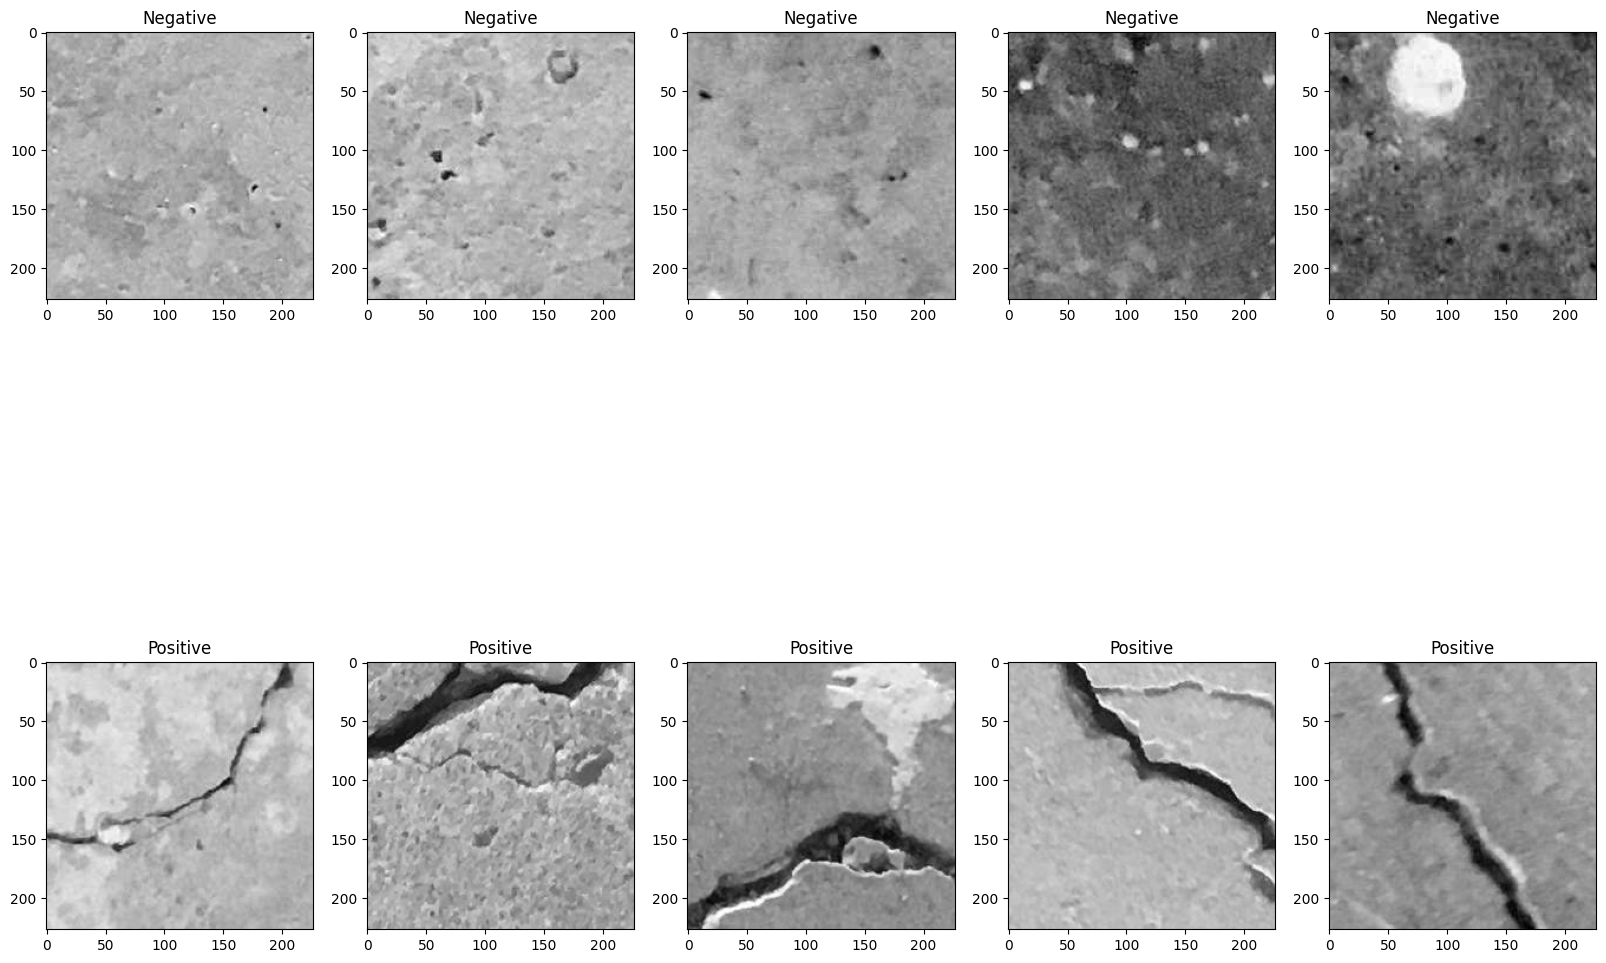

In [ ]:
# define sample of dataset
negative_sample = (data[data['Label']=='NEGATIVE']['Filepath'].iloc[:5]).tolist()
positive_sample = (data[data['Label']=='POSITIVE']['Filepath'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        ax[i // 5, i % 5].set_title(sample.split('/')[-2])
        ax[i // 5, i % 5].imshow(img_gray, cmap='gray') 
    plt.show()
# Execute the function
visualize_samples(negative_sample + positive_sample)

Transformasi grayscale dilakukan dengan mengubah image dari warna RGB menjadi grayscale. Dengan mengubah image menjadi grayscale, Anda dapat melihat image-image dalam skala keabuan, di mana intensitas piksel mewakili tingkat kecerahan dalam image. Ini dapat membantu dalam melihat pola kecerahan, perbedaan tekstur, dan bentuk objek dalam dataset gambar.

Terlihat pada hasil grayscale dengan dataset awal dengan warna original/RGB tidak ada perbedaan signifikan. Kemungkinan besar hal ini disebabkan oleh warna background dari dataset yang berwarna gabungan putih, coklat, dan abu-abu. Untuk area dengan label crack memiliki warna hitam/gelap pada area cracknya.

## **`5. Feature Engineering`**

### **5.1. Define Parameter**

In [ ]:
# set img_height, img_width, batch_size
img_height = 120
img_width = 120
batch_size = 32

### **5.2 Split Dataset ke Train - Test**

In [ ]:
# split data ke train dan test
train_df, test_df = train_test_split(data, 
                                     train_size=0.7, 
                                     random_state=42, 
                                     stratify=data[['Label']]
                                     )

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    )

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

Berikut adalah penjelasan tentang metric yang digunakan pada ImageDataGenerator:

- rescale=1/255: Melakukan penskalaan piksel gambar dalam rentang 0-255 menjadi rentang 0-1. Ini adalah bentuk normalisasi sederhana yang dilakukan pada setiap gambar.

- validation_split=0.2: Memecah dataset menjadi data pelatihan dan data validasi. Nilai 0.2 menunjukkan bahwa 20% dari data akan digunakan sebagai data validasi.

- width_shift_range=0.2: Menggeser gambar secara horizontal dengan kisaran maksimum 20% lebar gambar.

- height_shift_range=0.2: Menggeser gambar secara vertikal dengan kisaran maksimum 20% tinggi gambar.

- shear_range=0.2: Menerapkan transformasi shear pada gambar dengan kisaran maksimum 20%.

- horizontal_flip=True: Menerapkan flip horizontal pada gambar. Ini berarti gambar dapat diputar secara horizontal.

### **5.3. Augmentasi Data**

In [ ]:
# Tensorflow pipeline untuk augmentasi

train_images = train_gen.flow_from_dataframe(train_df,
                                             x_col='Filepath',
                                             y_col='Label',
                                             target_size=(img_height, img_width),
                                             color_mode='rgb',
                                             class_mode='binary',
                                             batch_size= batch_size,
                                             shuffle=True,
                                             seed = 42,
                                             subset='training'
                                             )

val_images = train_gen.flow_from_dataframe(train_df,
                                             x_col='Filepath',
                                             y_col='Label',
                                             target_size=(img_height, img_width),
                                             color_mode='rgb',
                                             class_mode='binary',
                                             batch_size= batch_size,
                                             shuffle=True,
                                             seed = 42,
                                             subset='validation'
                                             )

test_images = test_gen.flow_from_dataframe(test_df,
                                           x_col='Filepath',
                                           y_col='Label',
                                           target_size=(img_height, img_width),
                                           color_mode='rgb',
                                           class_mode='binary',
                                           batch_size= batch_size,
                                           shuffle=False,
                                           seed = 42
                                           )

Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


Augmentasi merupakan suatu teknik untuk memperluas atau memperbesar data sehingga model dapat melakukan generalisasi. 

Pada bagian augmentasi saya melakukan rescale, rotasi, pergeseran gambar secara horizontal dan vertikal, dan membalikan gambar secara horizontal. Hal ini dilakukan untuk mencegah adannya overfitting dan model mengenali pola yang bermacam-macam.

Saya menentukan beberapa setting dasar yang akan digunakan dibagian lain dari notebook, seperti ukuran image, kerandoman atau seed, jumlah batch, dan inputs.

## **`6. Model Definition`**

Penjelasan mengenai algoritma yang dipakai, hyperparameter, jenis metrics yang dipakai, dan hal lain terkait model

Algoritma pada model ini adalah functional API sebagai base model dan kemudian akan di improve dengan beberapa parameter seperti jumlah layer, ukuran kernel, jumlah filter, dan jumlah layer neuron untuk hyperparameter. Berikut adalah penjelasannya:

`Base Model`:

- Arsitektur Model: menggunakan arsitektur baseline model yang lebih sederhana. Terdiri dari beberapa layer Conv2D, MaxPooling2D, Flatten, dan Dense.

- Jumlah Filter: jumlah filter yang lebih sedikit, yaitu 8 dan 16 pada Conv2D layer.

- Tipe Layer Output: Menggunakan layer Dense dengan 64 neuron dan fungsi aktivasi sigmoid sebagai output layer.

- Evaluasi Metrics: Menggunakan metrik akurasi (accuracy) sebagai metrik evaluasi yang umum digunakan.


`Improved Model`:

- Arsitektur Model: Terdiri dari beberapa layer Conv2D, MaxPooling2D, GlobalAveragePooling2D, dan Dense.

- Jumlah Filter: model improved menggunakan jumlah filter yang lebih banyak, yaitu 16 dan 32 pada Conv2D layer.

- Tipe Layer Output: Menggunakan layer Dense dengan 128 neuron dan fungsi aktivasi sigmoid sebagai output layer.

- Evaluasi Metrics: Menggunakan metrik akurasi (accuracy) sebagai metrik evaluasi yang umum digunakan.

## **`7. Model Training`**

In [ ]:
#define callbacks
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1),
             ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)]

### **7.1. Baseline Model**
Untuk baseline model saya menggunakan functional API yang akan diukur performa model tersebut

In [ ]:
# buat arsitektur baseline model
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# buat base model
base = tf.keras.Model(inputs=inputs, outputs=outputs)
base.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0   

In [ ]:
# Compile base model
base.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#training baseline
%%time
history_base = base.fit(
    train_images,
    validation_data=val_images,
    epochs=21,
    callbacks=callbacks
)

Epoch 1/21
700/700 [==============================] - 316s 450ms/step - loss: 0.1807 - accuracy: 0.9321 - val_loss: 0.0689 - val_accuracy: 0.9820
Epoch 2/21
700/700 [==============================] - 325s 464ms/step - loss: 0.0684 - accuracy: 0.9782 - val_loss: 0.1518 - val_accuracy: 0.9532
Epoch 3/21
700/700 [==============================] - 304s 434ms/step - loss: 0.0655 - accuracy: 0.9807 - val_loss: 0.0510 - val_accuracy: 0.9850
Epoch 4/21
700/700 [==============================] - 306s 437ms/step - loss: 0.0541 - accuracy: 0.9833 - val_loss: 0.0605 - val_accuracy: 0.9834
Epoch 5/21
700/700 [==============================] - 318s 454ms/step - loss: 0.0534 - accuracy: 0.9842 - val_loss: 0.0650 - val_accuracy: 0.9795
Epoch 6/21
700/700 [==============================] - 367s 524ms/step - loss: 0.0525 - accuracy: 0.9835 - val_loss: 0.0477 - val_accuracy: 0.9857
Epoch 7/21
700/700 [==============================] - 318s 455ms/step - loss: 0.0480 - accuracy: 0.9851 - val_loss: 0.0480 -

In [ ]:
fig_base = px.line(
    history_base.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epochs", 'value':"Loss"},
    title=("Training and Validation Loss over Time")
)

fig_base.show()

Dari hasil train diatas, terlihat masih adanya data explotion saat epoch 0 menuju 1. Ini dapat berarti model sempat mengalami overfitting dan data ini berlanjut pada epoch 2-4 dan epoch 10-12. Yang menandakan model masih kurang baik dalam proses training

### **7.2. Improved Model**

In [ ]:
# Buat arsitektur improved model
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
# buat model_improvement
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0   

In [ ]:
# Compile improved model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Training improved model
%%time

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=21,
    callbacks=callbacks
)

Epoch 1/21
700/700 [==============================] - 426s 606ms/step - loss: 0.2305 - accuracy: 0.8849 - val_loss: 0.0598 - val_accuracy: 0.9829
Epoch 2/21
700/700 [==============================] - 416s 594ms/step - loss: 0.0601 - accuracy: 0.9807 - val_loss: 0.0888 - val_accuracy: 0.9679
Epoch 3/21
700/700 [==============================] - 415s 594ms/step - loss: 0.0518 - accuracy: 0.9828 - val_loss: 0.0835 - val_accuracy: 0.9727
Epoch 4/21
700/700 [==============================] - 410s 586ms/step - loss: 0.0501 - accuracy: 0.9836 - val_loss: 0.0491 - val_accuracy: 0.9852
Epoch 5/21
700/700 [==============================] - 369s 527ms/step - loss: 0.0358 - accuracy: 0.9892 - val_loss: 0.0512 - val_accuracy: 0.9829
Epoch 6/21
700/700 [==============================] - 367s 523ms/step - loss: 0.0375 - accuracy: 0.9881 - val_loss: 0.0349 - val_accuracy: 0.9880
Epoch 7/21
700/700 [==============================] - 410s 586ms/step - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.0269 -

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epochs", 'value':"Loss"},
    title=("Training and Validation Loss over Time")
)

fig.show()

Dari train pada model improvement lonjakan atau explotion sudah berkurang namun tidak menghilang sepenuhnya pada proses train. Namun dari sisi waktu train cukup berkurang lebih cepat 3 menit. Waktu train yang lama juga disebabkan oleh berakhirnya timelimit akselerasi GPU oleh Colab yang sudah berlangsung lebih dari 12 jam. Sehingga waktu train sepenuhnya dilakukan oleh CPU. Meski begitu, tetap terlihat adanya peningkatan performa sehingga waktu train menjadi lebih cepat.

## **`8. Model Evaluation`**

#### **8.1.1. Baseline Result**

375/375 [==============================] - 57s 151ms/step
Test Loss: 0.03967
Accuracy: 98.95%


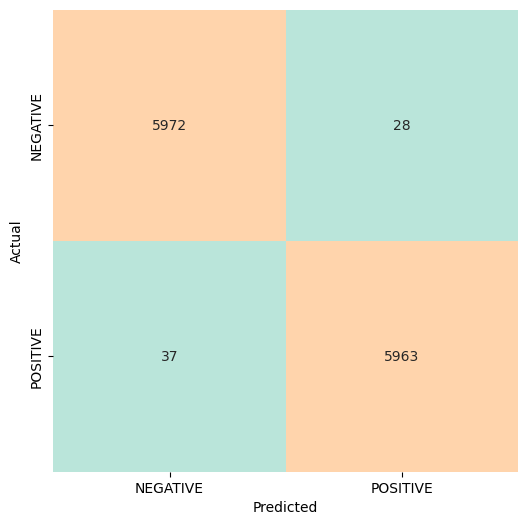

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      0.99      6000
    POSITIVE       1.00      0.99      0.99      6000

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [ ]:
y_pred = (model.predict(test_images).squeeze() >= 0.5).astype(int)

def evaluate_model(model):
    
    results = model.evaluate(test_images, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("Test Loss: {:.5f}".format(loss))
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    cm = confusion_matrix(test_images.labels, y_pred)
    clr = classification_report(test_images.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='icefire', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("Classification Report:\n------------------------------\n", clr)

evaluate_model(base)


- Hasil dari confusion matrix memiliki nilai yang baik pada metrics pantauan yaitu F1-score senilai 0.99 baik dari negative/normal maupun postive/crack surface area. 

- Nilai accuracy total adalah 98,95% dengan waktu training selama 1 jam 17 menit 54 detik. 

#### **8.1.2. Display Baseline Result**

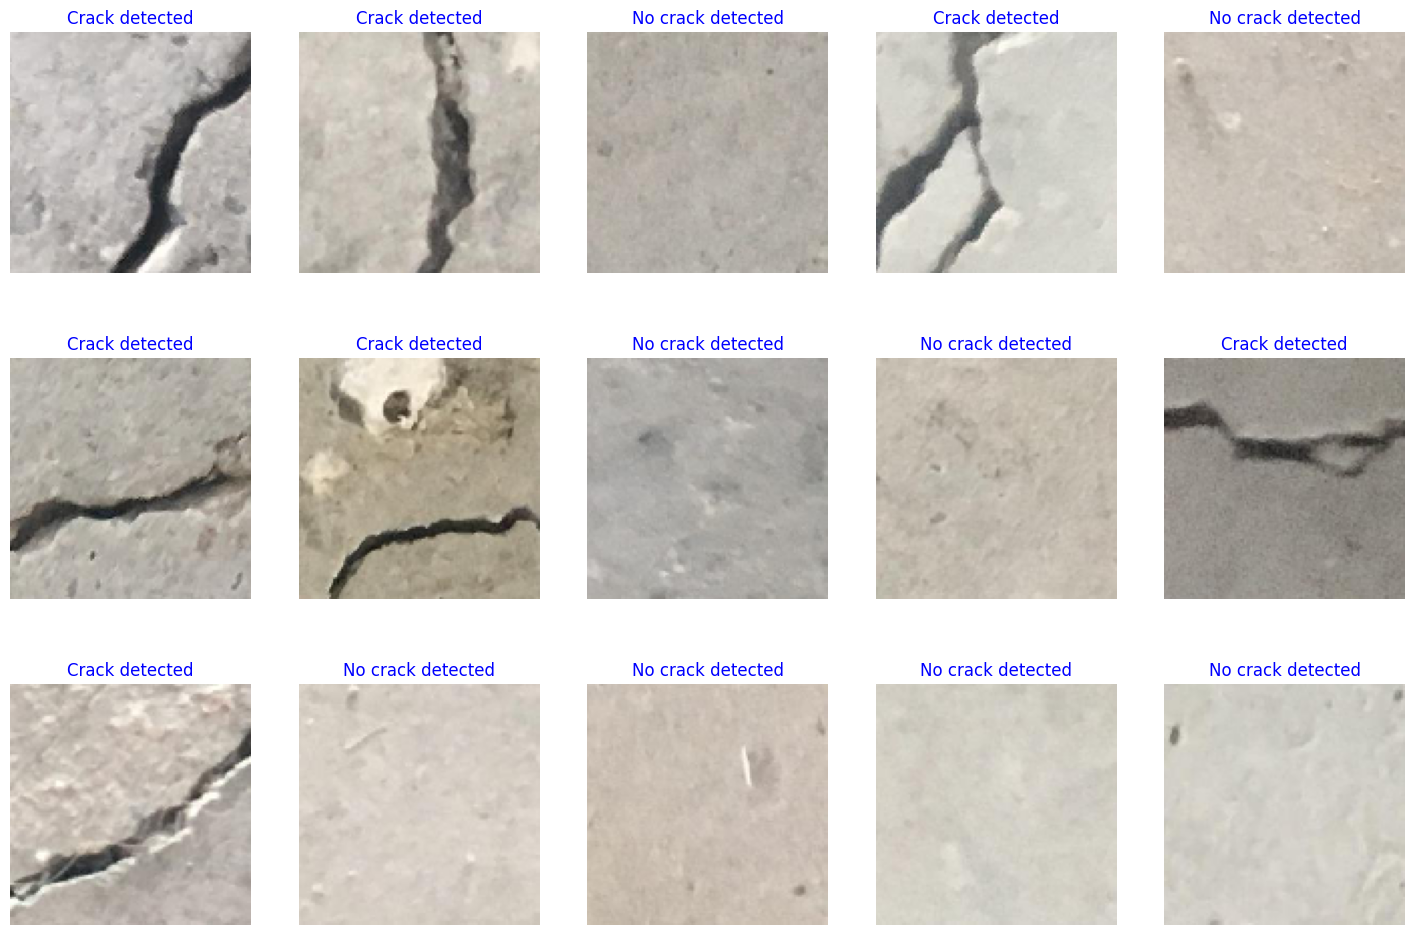

In [ ]:
plt.figure(figsize=(18, 12))

for i in range(15):
    
    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[0][0][i])
    plt.title("No crack detected" if y_pred[i] == 0 else "Crack detected",
              color='blue' if y_pred[i] == test_images.labels[i] else 'red')
    plt.axis('off')
    
plt.show()


Berikut adalah contoh hasil dari model yang mendeteksi secara akurat.

#### **8.2.1. Result Improved Model**

Test Loss: 0.01604
Accuracy: 99.46%


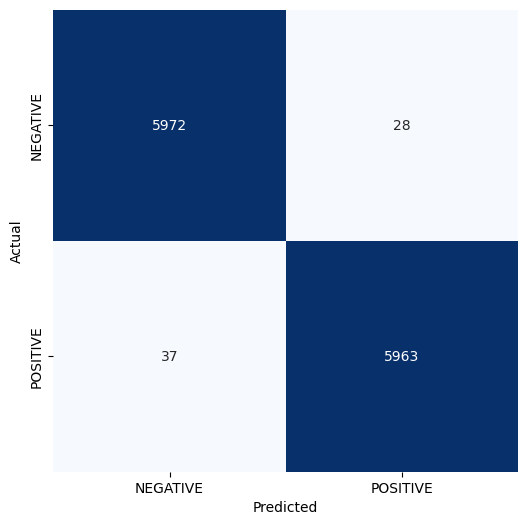

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      0.99      6000
    POSITIVE       1.00      0.99      0.99      6000

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [ ]:
# check result improved model 
evaluate_model(model)

- Hasil dari confusion matrix improvement memiliki nilai yang sama baik pada metrics pantauan yaitu F1-score senilai 0.99 baik dari negative/normal maupun postive/crack surface area. 

- Perbedaan dengan baseline model adalah **nilai accuracy total meningkat menjadi 99,46%** dengan waktu training berkurang menjadi 1 jam 14 menit 53 detik. 

- Confusion matriks menampilkan nilai false positive dan false negative berjumlah total 65 image keselahan prediksi. 

#### **8.2.2 Display Result Improved Model**

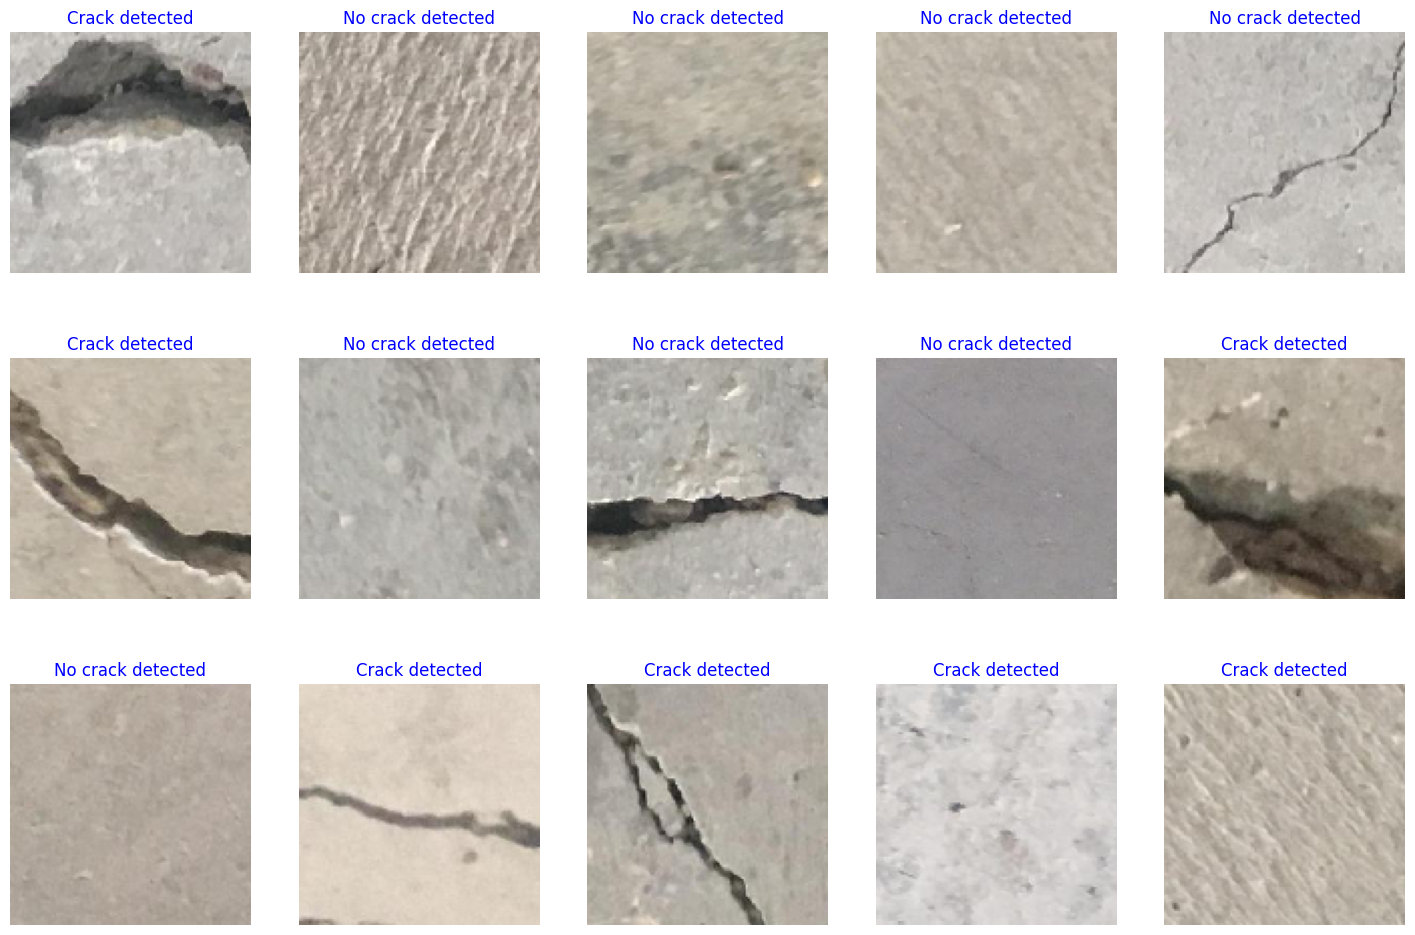

In [ ]:
# Mengambil 15 indeks gambar secara acak
random_indexes = random.sample(range(len(test_images)), 15)

plt.figure(figsize=(18, 12))

for i, index in enumerate(random_indexes):
    image, _ = next(test_images)  # Mendapatkan batch gambar berikutnya
    image = image[0]  # Mengambil gambar pertama dari batch
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title("No crack detected" if y_pred[index] == 0 else "Crack detected",
              color='blue' if y_pred[index] == test_images.labels[index] else 'red')
    plt.axis('off')

plt.show()

Berikut adalah hasil lainnya yang berhasil diprediksi oleh model improvement.

#### **8.2.3. Display Mistakes Improved Model**

65 mistakes.
Indices: [  195   240   330   735  1513  1637  1694  1739  2211  2348  2747  2809
  2840  3192  3640  3660  3687  3756  3875  4087  4139  4166  4303  4324
  5014  5210  5249  5430  5477  6030  6794  6852  6880  6927  7259  7291
  7381  7596  7680  7749  8057  8170  8209  8333  8351  9037  9590  9604
  9740  9961 10272 10293 10631 10671 10799 10819 10854 10973 11031 11210
 11347 11423 11482 11552 11927]


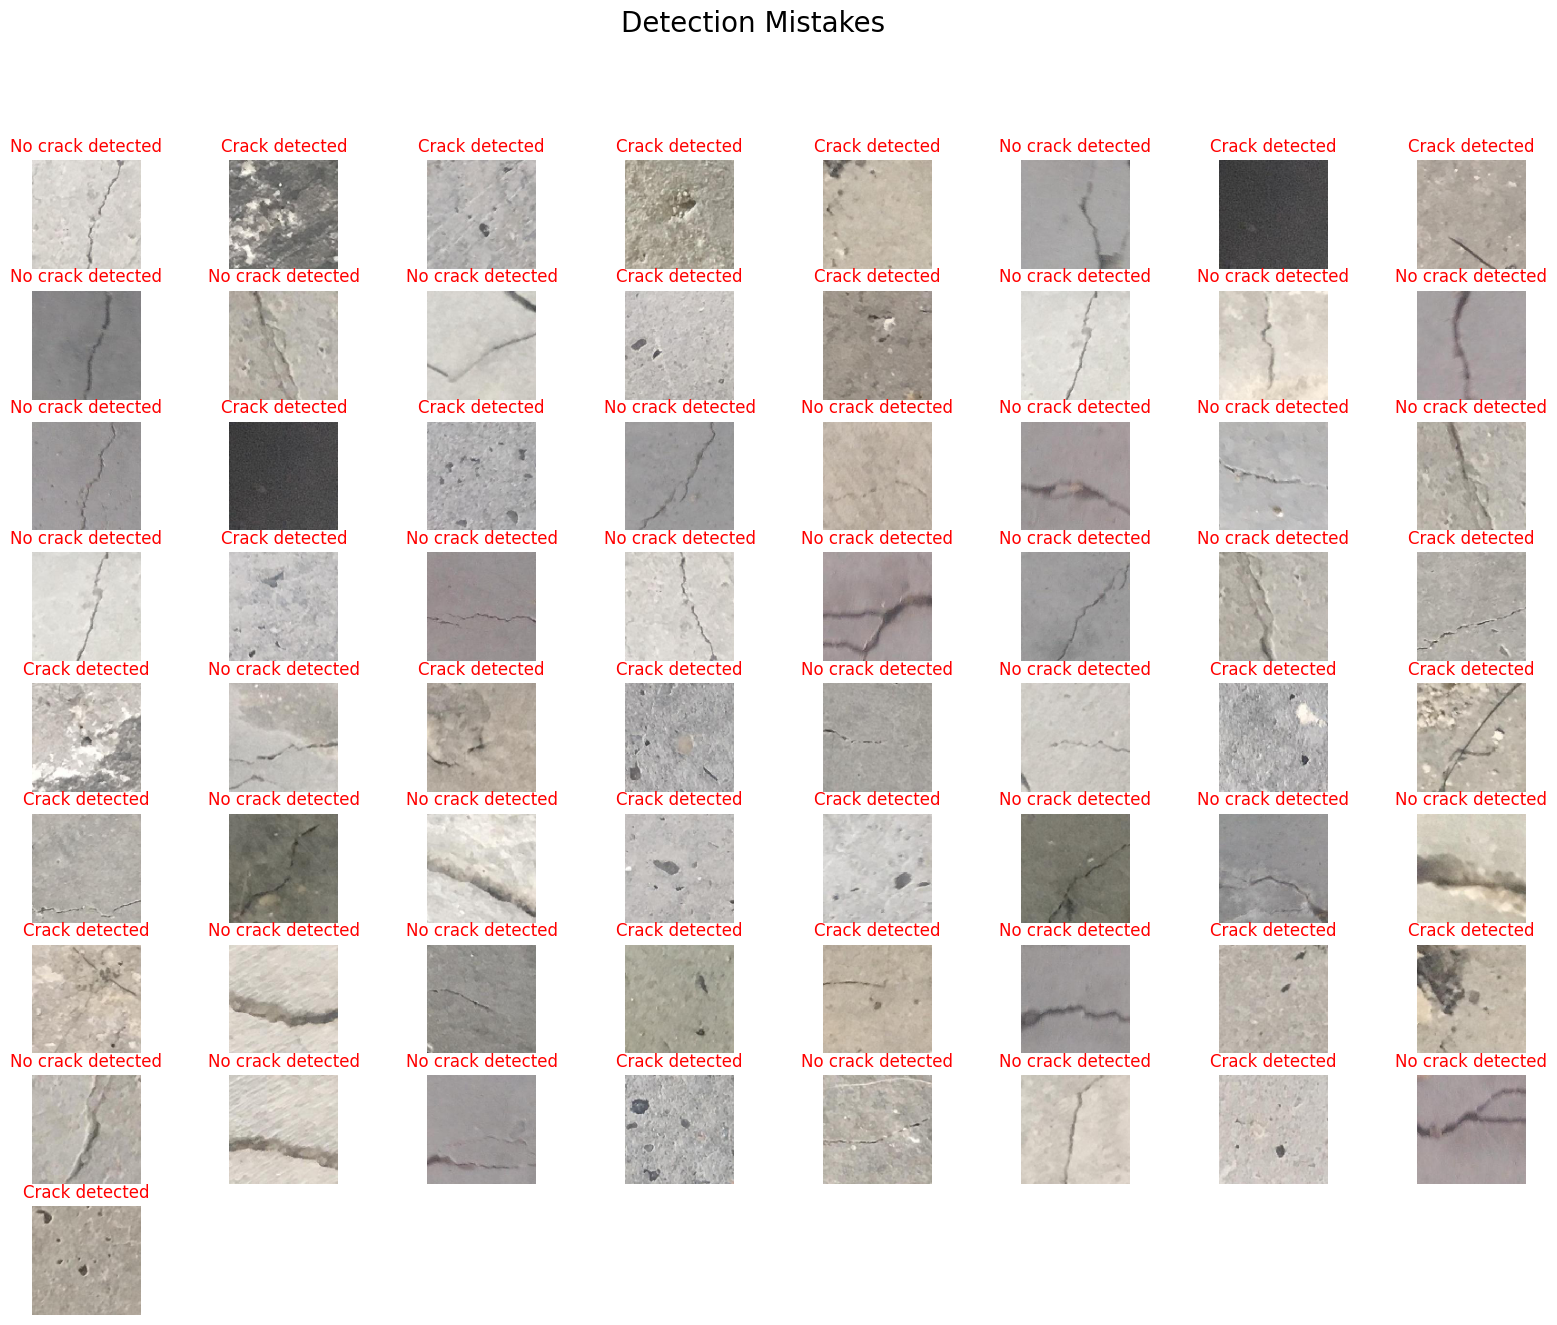

In [ ]:
mistake_idx = (y_pred != test_images.labels).nonzero()[0]
print(len(mistake_idx), "mistakes.")
print("Indices:", mistake_idx)

plt.figure(figsize=(20, 15))

num_plots = len(mistake_idx)
num_rows = (num_plots - 1) // 8 + 1

for i, idx in enumerate(mistake_idx):
    # Dapatkan batch dan nomor gambar
    batch = idx // 32
    image = idx % 32
    
    # Dapatkan gambar dari batch yang sesuai
    image = test_images[batch][0][image]
    
    plt.subplot(num_rows, 8, i+1)
    plt.imshow(image)
    plt.title("No crack detected" if y_pred[idx] == 0 else "Crack detected", color='red')
    plt.axis('off')

plt.suptitle("Detection Mistakes", fontsize=20)
plt.show()

Gambar diatas merupakan kesalahan prediksi dari model yang telah di improve. Dari gambar terlihat bahwa ada kesalahan prediksi yang muncul diakibatkan adanya `lubang namun tidak retak` yang menyebabkan model memprediksi hal itu sebagai keretakan. 

#### **`8.3. Best Model`**

Berdasarkan improvement yang dilakukan pada base model yang menggunakan functional API didapatkan hasil yang sangat baik terlihat di beberap metric yang dihasilkan seperti f1-score dan waktu train model yang berkurang dari 1 jam 17 menit menjadi 1 jam 14 menit. Maka dari itu, diputuskan untuk menggunakan improved functional API untuk model saving dan pada sistem deployment.

## **`9. Model Saving`**

In [ ]:
# freeze kedua model
base.trainable = False
model.trainable = False

In [ ]:
base.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0   

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0   

In [ ]:
#save CNN model
base.save('base_model.h5')
model.save('improved_model.h5')

## **`10. Model Inference`**

Model inference akan dilakukan di notebook `h8dsft_P2M2_Andika_Atmanegara_Putra_inference.ipynb`.

## **`11. Kesimpulan`**

Dari proses EDA (Exploratory Data Analysis), pemodelan, dan improvement yang telah dilakukan, beberapa kesimpulan dan saran terkait penggunaan model ini misalnya pada perusahaan kontruksi bangunan adalah sebagai berikut:

`Kesimpulan`:

- Dataset: Dataset yang digunakan terdiri dari image yang telah dikategorikan sebagai positif (image cacat atau masalah konstruksi) dan negatif (image tanpa cacat). Dataset tersebut dapat digunakan untuk melatih model dalam melakukan klasifikasi otomatis terhadap image konstruksi.

- Transformasi Citra: Tujuan dari transformasi citra seperti perubahan hue, saturation, LUV color image, dan grayscale adalah untuk memodifikasi tampilan visual atau representasi citra dalam berbagai cara untuk kebutuhan analisa data seperti melihat warna dominan pada dataset yaitu gabungan antara warna putih, coklat, dan abu-abu. Agar kedepannya dataset lebih dapat bervariasi sehingga meningkatkan performa model menjadi lebih baik. 

- Augmentasi Data: Dilakukan augmentasi data pada proses training dengan menggunakan teknik seperti rescaling, shift, shear, dan horizontal flip. Hal ini membantu meningkatkan variasi data yang digunakan dalam pelatihan dan dapat meningkatkan kemampuan generalisasi model untuk memprediksi image. 

- Arsitektur Model: Dua arsitektur model telah dibandingkan, yaitu baseline model dan improved model. Improved model menggunakan arsitektur yang lebih kompleks dengan menggunakan layer Convolutional dan Global Average Pooling. Dalam pengujian, improved model memberikan hasil yang lebih baik dalam hal akurasi dan loss.

  **Base Model:**

  Arsitektur Model: menggunakan arsitektur baseline model yang lebih sederhana. Terdiri dari beberapa layer Conv2D, MaxPooling2D, Flatten, dan Dense.

  Jumlah Filter: jumlah filter yang lebih sedikit, yaitu 8 dan 16 pada Conv2D layer.

  Tipe Layer Output: Menggunakan layer Dense dengan 128 neuron dan fungsi aktivasi sigmoid sebagai output layer.

  Evaluasi Metrics: Menggunakan metrik akurasi (accuracy) sebagai metrik evaluasi yang umum digunakan.

  **Improved Model:**

  Arsitektur Model: Terdiri dari beberapa layer Conv2D, MaxPooling2D, GlobalAveragePooling2D, dan Dense.

  Jumlah Filter: model improved menggunakan jumlah filter yang lebih banyak, yaitu 16 dan 32 pada Conv2D layer.

  Tipe Layer Output: Menggunakan layer Dense dengan 64 neuron dan fungsi aktivasi sigmoid sebagai output layer.

  Evaluasi Metrics: Menggunakan metrik akurasi (accuracy) sebagai metrik evaluasi yang umum digunakan.

---

`Saran`:

- Pengumpulan Data Lebih Lanjut: Untuk meningkatkan kinerja model, perusahaan konstruksi disarankan untuk mengumpulkan lebih banyak data gambar yang mewakili berbagai jenis cacat atau masalah konstruksi yang mungkin terjadi. Semakin banyak variasi dalam data, semakin baik model dapat menggeneralisasi dan mengenali pola-pola yang berbeda.

- Fine-Tuning: Setelah memiliki model yang baik, perusahaan dapat melanjutkan dengan fine-tuning model tersebut seperti menggunakan data internal yang lebih spesifik terkait proyek-proyek konstruksi yang telah dilakukan sebelumnya. Dengan demikian, model dapat diadaptasi lebih baik untuk kasus penggunaan perusahaan dan menghasilkan hasil yang lebih akurat.

- Integrasi dengan Sistem Perusahaan: Perusahaan konstruksi perlu mempertimbangkan integrasi model ini dengan sistem mereka, sehingga model dapat digunakan secara praktis dalam mengklasifikasikan gambar konstruksi secara real-time. 

- Pemeliharaan dan Evaluasi Terus-menerus: Model perlu dipelihara dan dievaluasi secara berkala untuk memastikan kinerjanya tetap optimal. 

Dengan mengikuti saran-saran di atas, perusahaan konstruksi dapat memanfaatkan model ini untuk membantu dalam proses pengenalan dan deteksi masalah konstruksi secara otomatis, meningkatkan efisiensi, dan mengurangi risiko dalam proyek-proyek konstruksi.